# Splitting the dataset

### Import Libraries

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

### Function to get the DataFrame for a specific driver and path order

In [226]:
def driver_dataframe(df, path_order, driver):
    """
    Extracts and processes the DataFrame for a specific driver and path order.

    Parameters:
    df (DataFrame): The original DataFrame.
    path_order (int): The path order identifier.
    driver (str): The driver class identifier.

    Returns:
    DataFrame: Processed DataFrame for the specified driver and path order.
    """
    driver_df = df[df['PathOrder'] == path_order]
    driver_df = driver_df[driver_df['Class'] == driver]
    driver_df = driver_df.sort_values(by='Time(s)')
    driver_df.drop(columns=['Class', 'PathOrder'], inplace=True)
    driver_df = driver_df.groupby('Time(s)').mean()
    driver_df['Time(s)'] = driver_df.index
    return driver_df

### Function to split the dataset

In [227]:
def split_dataset(df, train_ratio=0.8, random_seed=123):
    """
    Splits the dataset into training and testing sets based on driver and path order.

    Parameters:
    df (DataFrame): The original DataFrame.
    train_ratio (float): Ratio of the dataset to be used for training. Default is 0.8.
    random_seed (int): Seed for random number generator. Default is 123.

    Returns:
    DataFrame: Training set.
    DataFrame: Testing set.
    """

    # set a random seed
    np.random.seed(random_seed)

    # create a copy of dataframe
    df_copy = df.copy()

    # Lists to hold individual DataFrames
    df_train = []
    df_test = []

    # Nested loops to process each path and driver
    for path in df_copy['PathOrder'].unique():
        for driver in df_copy['Class'].unique():
            driver_df = driver_dataframe(df_copy, path, driver)
            driver_df['PathOrder'] = path  # Add PathOrder
            driver_df['Class'] = driver    # Add Class

            # Calculate the index to split the data
            split_index = int(train_ratio * len(driver_df))

            # Split the data
            df_train_split = driver_df.iloc[:split_index]
            df_test_split = driver_df.iloc[split_index:]

            # Append the data to df_train and df_test lists
            df_train.append(df_train_split)
            df_test.append(df_test_split)

    # Concatenate the DataFrames
    df_train = pd.concat(df_train, ignore_index=True)
    df_test = pd.concat(df_test, ignore_index=True)

    return df_train, df_test

In [228]:
selected_features = ['Engine_soacking_time', 'Long_Term_Fuel_Trim_Bank1', 'Engine_coolant_temperature.1',
 'Torque_of_friction', 'Activation_of_Air_compressor', 'Intake_air_pressure', 'PathOrder', 'Accelerator_Pedal_value',
 'Master_cylinder_pressure', 'Vehicle_speed','Engine_coolant_temperature', 'Maximum_indicated_engine_torque',
 'Throttle_position_signal', 'Current_Gear', 'Calculated_LOAD_value', 'Engine_torque_after_correction',
 'Engine_torque', 'Class', 'Time(s)']

In [229]:
data = pd.read_csv("Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv")

In [230]:
selected_df = data[selected_features]

In [231]:
selected_df.head()

,Engine_soacking_time,Long_Term_Fuel_Trim_Bank1,Engine_coolant_temperature.1,Torque_of_friction,Activation_of_Air_compressor,Intake_air_pressure,PathOrder,Accelerator_Pedal_value,Master_cylinder_pressure,Vehicle_speed,Engine_coolant_temperature,Maximum_indicated_engine_torque,Throttle_position_signal,Current_Gear,Calculated_LOAD_value,Engine_torque_after_correction,Engine_torque,Class,Time(s)
0,3,-0.8,87,9.0,0,33,1,0.0,325.5,0,95,58.2,5.2,0,23.9,5.5,5.5,A,1
1,3,-0.8,87,7.8,0,40,1,0.0,0.9,0,95,53.9,6.1,0,30.6,7.0,7.0,A,2
2,3,-0.8,87,7.4,0,41,1,0.0,0.9,0,95,53.1,5.2,0,31.8,7.0,7.0,A,3
3,3,-0.8,87,6.6,0,38,1,0.0,0.9,0,95,53.1,4.7,0,29.0,7.0,7.0,A,4
4,3,-0.8,87,11.3,1,40,1,0.0,0.9,0,95,53.5,5.7,0,30.2,8.2,8.2,A,5


In [232]:
df_train, df_test = split_dataset(selected_df, 0.8)

In [233]:
df_train.shape

(37059, 19)

In [234]:
df_test.shape

(9277, 19)

In [235]:

def driver_dataframe_using_window_size(df, path_order, driver, window_size=60):
    """
    Extracts and processes the DataFrame for a specific driver and path order,
    and calculates rolling statistics with the specified window size.

    Parameters:
    df (DataFrame): The original DataFrame.
    path_order (int): The path order identifier.
    driver (str): The driver class identifier.
    window_size (int): The size of the rolling window.

    Returns:
    DataFrame: Processed DataFrame for the specified driver and path order with
               rolling statistics concatenated to the original features.
    """

    # Filter the DataFrame for the specific driver and path order
    driver_df = df[df['PathOrder'] == path_order]
    driver_df = driver_df[driver_df['Class'] == driver]


    # Drop the 'Class' and 'PathOrder' columns
    time = driver_df['Time(s)']
    driver_df.drop(columns=['Class', 'PathOrder', 'Time(s)'], inplace=True)


    # Calculate rolling statistics
    rolling_mean = driver_df.rolling(window=window_size).mean().add_suffix('_mean')
    rolling_median = driver_df.rolling(window=window_size).median().add_suffix('_median')
    rolling_std = driver_df.rolling(window=window_size).std().add_suffix('_std')
#     rolling_var = driver_df.rolling(window=window_size).var().add_suffix('_var')
#     rolling_min = driver_df.rolling(window=window_size).min().add_suffix('_min')
#     rolling_max = driver_df.rolling(window=window_size).max().add_suffix('_max')

    # Concatenate the original features with the rolling statistics
    # , rolling_var, rolling_min, rolling_max
    driver_df = pd.concat([driver_df, rolling_mean, rolling_median, rolling_std], axis=1)
    driver_df['Time(s)'] = time
    # Drop the first 'window_size' rows to make the concatenation match
    driver_df = driver_df.iloc[window_size-1:]

    return driver_df


In [236]:
def prepare_all_drivers(df, random_seed=123):
    """
    Prepares the dataset by processing each driver's data and calculating rolling statistics for each feature.

    Parameters:
    df (DataFrame): The original DataFrame.
    random_seed (int): The seed for the random number generator (default is 123).

    Returns:
    DataFrame: Processed DataFrame with rolling statistics and necessary columns for all drivers.
    """

    # Set the random seed for reproducibility
    np.random.seed(random_seed)

    # Create a copy of the original DataFrame to ensure the original data is not altered
    df_copy = df.copy()

    # List to hold individual DataFrames for each driver and path
    df_temp = []

    # Nested loops to process each path and driver
    for path in df_copy['PathOrder'].unique():
        for driver in df_copy['Class'].unique():
            # Process the DataFrame for the specific driver and path using window size
            driver_df = driver_dataframe_using_window_size(df_copy, path, driver)
            driver_df['PathOrder'] = path  # Add PathOrder column
            driver_df['Class'] = driver    # Add Class column

            # Append the processed DataFrame to the list
            df_temp.append(driver_df)

    # Concatenate all individual DataFrames into a single DataFrame
    all_drivers = pd.concat(df_temp, ignore_index=True)

    return all_drivers

In [237]:
df_train_preprocessed = prepare_all_drivers(df_train)
df_test_preprocessed = prepare_all_drivers(df_test)

In [238]:
df_train_preprocessed.head()

,Engine_soacking_time,Long_Term_Fuel_Trim_Bank1,Engine_coolant_temperature.1,Torque_of_friction,Activation_of_Air_compressor,Intake_air_pressure,Accelerator_Pedal_value,Master_cylinder_pressure,Vehicle_speed,Engine_coolant_temperature,Maximum_indicated_engine_torque,Throttle_position_signal,Current_Gear,Calculated_LOAD_value,Engine_torque_after_correction,Engine_torque,Engine_soacking_time_mean,Long_Term_Fuel_Trim_Bank1_mean,Engine_coolant_temperature.1_mean,Torque_of_friction_mean,Activation_of_Air_compressor_mean,Intake_air_pressure_mean,Accelerator_Pedal_value_mean,Master_cylinder_pressure_mean,Vehicle_speed_mean,Engine_coolant_temperature_mean,Maximum_indicated_engine_torque_mean,Throttle_position_signal_mean,Current_Gear_mean,Calculated_LOAD_value_mean,Engine_torque_after_correction_mean,Engine_torque_mean,Engine_soacking_time_median,Long_Term_Fuel_Trim_Bank1_median,Engine_coolant_temperature.1_median,Torque_of_friction_median,Activation_of_Air_compressor_median,Intake_air_pressure_median,Accelerator_Pedal_value_median,Master_cylinder_pressure_median,Vehicle_speed_median,Engine_coolant_temperature_median,Maximum_indicated_engine_torque_median,Throttle_position_signal_median,Current_Gear_median,Calculated_LOAD_value_median,Engine_torque_after_correction_median,Engine_torque_median,Engine_soacking_time_std,Long_Term_Fuel_Trim_Bank1_std,Engine_coolant_temperature.1_std,Torque_of_friction_std,Activation_of_Air_compressor_std,Intake_air_pressure_std,Accelerator_Pedal_value_std,Master_cylinder_pressure_std,Vehicle_speed_std,Engine_coolant_temperature_std,Maximum_indicated_engine_torque_std,Throttle_position_signal_std,Current_Gear_std,Calculated_LOAD_value_std,Engine_torque_after_correction_std,Engine_torque_std,Time(s),PathOrder,Class
0,129.0,0.0,61.0,20.50,1.0,49.5,1.00,1.00,16.5,62.0,67.20,8.45,2.5,38.6,23.85,23.85,129.0,-0.073333,59.733333,19.954167,0.933333,59.125000,1.562500,11.056667,3.925000,61.666667,63.302500,8.945000,5.566667,48.150000,25.255833,25.253333,129.0,0.0,59.5,20.5,1.0,59.5,0.0,1.95,2.00,61.5,61.15,8.95,7.0,48.425,26.65,26.55,0.0,0.289867,0.384737,2.605979,0.251549,10.812197,2.847756,30.029674,5.114639,0.447845,4.325598,1.904382,2.808080,10.501307,7.898869,7.977537,60,1,A
1,129.0,0.0,61.0,19.95,0.5,46.5,0.40,1.45,16.0,62.0,66.40,8.00,2.5,36.3,21.30,21.30,129.0,-0.066667,59.758333,20.075000,0.941667,58.983333,1.569167,8.300833,4.191667,61.658333,63.348333,8.952500,5.608333,48.016667,25.395833,25.435833,129.0,0.0,59.5,20.5,1.0,59.5,0.0,1.80,2.00,61.5,61.15,8.95,7.0,48.425,26.65,26.55,0.0,0.286810,0.416723,2.425771,0.227210,10.922286,2.844502,22.011446,5.319529,0.436586,4.343873,1.899675,2.741847,10.601330,7.749184,7.752906,61,1,A
2,129.0,0.0,61.0,17.20,0.5,45.5,1.95,1.00,15.0,62.0,65.80,8.00,2.5,35.1,20.50,20.50,129.0,-0.060000,59.783333,20.166667,0.950000,59.091667,1.601667,5.559167,4.441667,61.650000,63.354167,8.975833,5.650000,48.117500,25.636667,25.676667,129.0,0.0,59.5,20.5,1.0,59.5,0.0,1.70,2.00,61.5,61.15,8.95,7.0,48.425,26.65,26.55,0.0,0.283561,0.444997,2.197064,0.199576,10.751623,2.837401,7.676116,5.469555,0.424863,4.346977,1.878773,2.673314,10.445499,7.352123,7.354714,62,1,A
3,129.0,-0.4,61.0,16.40,0.5,56.0,8.40,1.00,14.5,62.5,67.40,11.75,2.5,46.1,28.15,27.95,129.0,-0.060000,59.808333,20.251667,0.958333,59.466667,1.741667,5.561667,4.683333,61.650000,63.403333,9.073333,5.691667,48.483333,26.005000,26.041667,129.0,0.0,59.5,20.5,1.0,59.5,0.0,1.70,2.00,61.5,61.15,8.95,7.0,48.425,26.85,26.75,0.0,0.283561,0.470230,1.930728,0.167019,10.223298,2.961550,7.674580,5.589008,0.424863,4.376167,1.868210,2.602300,9.965192,6.893510,6.893114,63,1,A
4,129.0,-0.4,61.0,16.20,0.5,67.0,10.75,1.15,14.5,62.5,69.15,32.65,2.5,59.4,33.20,33.20,129.0,-0.060000,59.833333,20.340000,0.966667,60.050000,1.920833,5.565833,4.925000,61.650000,63.507500,9.523333,5.733333,49.094167,26.447500,26.484167,129.0,0.0,59.5,20.5,1.0,61.0,0.0,1.70,2.25,61.5,61.15,8.95,7.0,49.675,26.95,27.15,0.0,0.283561,0.492887,1.586110,0.125774,9.609626,3.17208

In [239]:
df_train_preprocessed.shape

(35879, 67)

In [240]:
df_test_preprocessed.shape

(8097, 67)

In [241]:
X_train = df_train_preprocessed.drop(columns=['Class'])
y_train = df_train_preprocessed[['Class']]

X_test = df_test_preprocessed.drop(columns=['Class'])
y_test = df_test_preprocessed[['Class']]

### RandomForest Model

In [242]:
# clf = RandomForestClassifier()

In [243]:
# clf.fit(X_train, y_train)

In [244]:
# pred = clf.predict(X_test)

In [245]:
# accuracy_score(y_test, pred)

In [246]:
# f1_score(pred, y_test, average='macro')

# AutoEncoder

In [247]:
df_driver_A_path_1 = driver_dataframe_using_window_size(selected_df, 1, "A", window_size=60)

In [248]:
df_driver_B_path_1 = driver_dataframe_using_window_size(selected_df, 1, "B", window_size=60)

In [249]:
df_driver_A_path_1.head()

,Engine_soacking_time,Long_Term_Fuel_Trim_Bank1,Engine_coolant_temperature.1,Torque_of_friction,Activation_of_Air_compressor,Intake_air_pressure,Accelerator_Pedal_value,Master_cylinder_pressure,Vehicle_speed,Engine_coolant_temperature,Maximum_indicated_engine_torque,Throttle_position_signal,Current_Gear,Calculated_LOAD_value,Engine_torque_after_correction,Engine_torque,Engine_soacking_time_mean,Long_Term_Fuel_Trim_Bank1_mean,Engine_coolant_temperature.1_mean,Torque_of_friction_mean,Activation_of_Air_compressor_mean,Intake_air_pressure_mean,Accelerator_Pedal_value_mean,Master_cylinder_pressure_mean,Vehicle_speed_mean,Engine_coolant_temperature_mean,Maximum_indicated_engine_torque_mean,Throttle_position_signal_mean,Current_Gear_mean,Calculated_LOAD_value_mean,Engine_torque_after_correction_mean,Engine_torque_mean,Engine_soacking_time_median,Long_Term_Fuel_Trim_Bank1_median,Engine_coolant_temperature.1_median,Torque_of_friction_median,Activation_of_Air_compressor_median,Intake_air_pressure_median,Accelerator_Pedal_value_median,Master_cylinder_pressure_median,Vehicle_speed_median,Engine_coolant_temperature_median,Maximum_indicated_engine_torque_median,Throttle_position_signal_median,Current_Gear_median,Calculated_LOAD_value_median,Engine_torque_after_correction_median,Engine_torque_median,Engine_soacking_time_std,Long_Term_Fuel_Trim_Bank1_std,Engine_coolant_temperature.1_std,Torque_of_friction_std,Activation_of_Air_compressor_std,Intake_air_pressure_std,Accelerator_Pedal_value_std,Master_cylinder_pressure_std,Vehicle_speed_std,Engine_coolant_temperature_std,Maximum_indicated_engine_torque_std,Throttle_position_signal_std,Current_Gear_std,Calculated_LOAD_value_std,Engine_torque_after_correction_std,Engine_torque_std,Time(s)
59,3,0.0,87,19.1,1,44,0.0,1.1,19,85,62.5,7.5,3,33.7,16.8,16.8,3.0,-0.200000,86.266667,18.671667,0.933333,59.400000,1.921667,10.826667,6.066667,89.950000,59.216667,8.570000,5.05,48.433333,23.788333,23.788333,3.0,0.0,86.0,19.1,1.0,64.0,0.0,1.1,3.0,90.0,54.3,8.00,2.0,52.55,25.6,25.8,0.0,0.349334,0.445948,3.337618,0.251549,12.296065,4.200811,42.745042,7.094679,3.538768,7.554058,2.707072,5.958685,11.774271,8.202317,8.207274,60
60,3,0.0,87,18.8,1,46,0.0,2.0,19,85,61.7,7.5,3,35.3,17.6,17.6,3.0,-0.186667,86.266667,18.835000,0.950000,59.616667,1.921667,5.435000,6.383333,89.783333,59.275000,8.608333,5.10,48.623333,23.990000,23.990000,3.0,0.0,86.0,19.1,1.0,64.0,0.0,1.1,3.5,90.0,54.3,8.00,2.0,52.55,25.6,25.8,0.0,0.341217,0.445948,3.086648,0.219784,11.932141,4.200811,10.981939,7.241808,3.532376,7.559585,2.674632,5.928100,11.459440,7.887766,7.892921,61
61,3,0.0,87,18.8,1,53,3.9,1.1,18,85,62.5,9.4,3,42.0,25.0,25.0,3.0,-0.173333,86.266667,19.018333,0.966667,59.833333,1.986667,5.438333,6.683333,89.616667,59.418333,8.663333,5.15,48.813333,24.290000,24.290000,3.0,0.0,86.0,19.1,1.0,64.0,0.0,1.1,4.0,90.0,54.3,8.00,2.0,52.55,25.6,25.8,0.0,0.332360,0.445948,2.725678,0.181020,11.685376,4.200745,10.980570,7.344989,3.517952,7.537443,2.656043,5.896925,11.248103,7.566377,7.571752,62
62,3,0.0,87,17.6,1,78,16.8,1.1,18,85,68.0,16.9,3,67.1,41.8,41.8,3.0,-0.160000,86.266667,19.188333,0.983333,60.450000,2.266667,5.441667,6.983333,89.450000,59.666667,8.858333,5.20,49.401667,24.870000,24.870000,3.0,0.0,86.0,19.1,1.0,64.5,0.0,1.1,4.0,90.0,54.5,8.25,2.0,53.50,25.8,26.0,0.0,0.322700,0.445948,2.268509,0.129099,11.650889,4.606394,10.979199,7.434440,3.495396,7.571124,2.821785,5.865151,11.266306,7.552333,7.557717,63
63,3,0.0,87,17.2,1,96,21.5,1.1,19,85,73.8,58.7,3,89.4,51.2,51.2,3.0,-0.146667,86.266667,19.365000,1.000000,61.416667,2.625000,5.445000,7.300000,89.283333,60.011667,9.758333,5.25,50.408333,25.606667,25.606667,3.0,0.0,86.0,19.1,1.0,65.0,0.0,1.1,4.0,90.0,55.5,8.50,2.0,54.10,25.8,26.2,0.0,0.312164,0.445948,1.579726,0.000000,12.151992,5.222170,10.977827,7.535903,3.464550,7.736642,6.996471,5.832768,12.081423,7.926139,7.931270,64


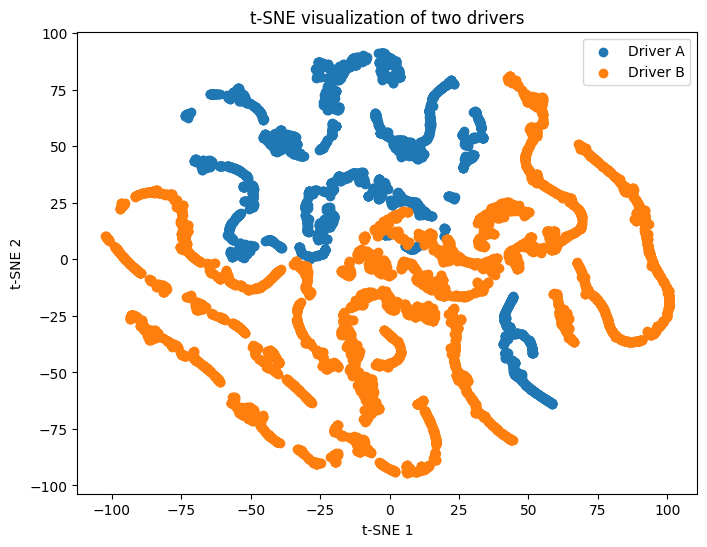

In [250]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Add a label to each dataframe
df_driver_A_path_1['label'] = 0
df_driver_B_path_1['label'] = 1

# Combine the dataframes
combined_df = pd.concat([df_driver_A_path_1, df_driver_B_path_1])

# Separate features and labels
X = combined_df.drop('label', axis=1)
y = combined_df['label']

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[y == 0, 0], X_tsne[y == 0, 1], label='Driver A')
plt.scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], label='Driver B')
plt.legend()
plt.title('t-SNE visualization of two drivers')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

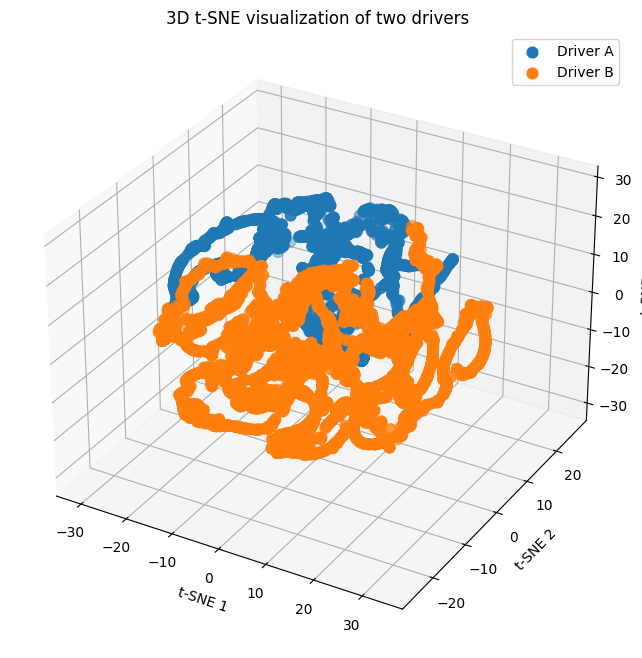

In [251]:
# Apply t-SNE
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_tsne[y == 0, 0], X_tsne[y == 0, 1], X_tsne[y == 0, 2], label='Driver A', s=60)
ax.scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], X_tsne[y == 1, 2], label='Driver B', s=60)

ax.set_title('3D t-SNE visualization of two drivers')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.legend()
plt.show()

In [252]:
df_driver_A_path_1.shape , df_driver_B_path_1.shape

((3137, 66), (6613, 66))

In [253]:
df_driver_A_path_1.drop(columns=['label'], inplace=True)
df_driver_B_path_1.drop(columns=['label'], inplace=True)

In [437]:
from sklearn.model_selection import train_test_split

# Split driver A data into training, validation, and test sets
train_df, temp_df = train_test_split(df_driver_B_path_1, test_size=0.4, random_state=42)
val_df, test_df_B = train_test_split(temp_df, test_size=0.5, random_state=42)

# Test set for mixed data
test_df_A = test_df_A = test_df_A = df_driver_A_path_1.sample(n=400, random_state=42)
test_df_A['label'] = 1
test_df_B['label'] = 0

# Combine the test set of driver A with the data of driver B
test_df = pd.concat([test_df_B, test_df_A])

# Separate features and labels in test set
test_features = test_df.drop('label', axis=1)
test_labels = test_df['label']

In [438]:
test_df_B.shape , test_df_A.shape

((1323, 66), (400, 66))

## Normalising & Standardising


In [256]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [257]:
# get normalization parameters by fitting to the training data
pipeline.fit(train_df)

Pipeline(steps=[('normalizer', Normalizer()), ('scaler', MinMaxScaler())])

In [258]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(train_df)
X_validate_transformed = pipeline.transform(val_df)

## Training the auto-encoder

In [259]:
import tensorflow as tf

# data dimensions // hyperparameters
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 500

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([

    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),

    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')

])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam",
                    loss="mse",
                    metrics=["acc"])

# print an overview of our model
autoencoder.summary();

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 65)                4290      
                                                                 
 dense_28 (Dense)            (None, 16)                1056      
                                                                 
 dense_29 (Dense)            (None, 8)                 136       
                                                                 
 dense_30 (Dense)            (None, 4)                 36        
                                                                 
 dense_31 (Dense)            (None, 2)                 10        
                                                                 
 dense_32 (Dense)            (None, 4)                 12        
                                                                 
 dense_33 (Dense)            (None, 8)                

In [260]:
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

# callbacks argument only takes a list
cb = [early_stop, save_model]

In [261]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

Epoch 1/500
16/16 [==============================] - 3s 21ms/step - loss: 0.0691 - acc: 0.0043 - val_loss: 0.0613 - val_acc: 0.0053
Epoch 2/500
16/16 [==============================] - 0s 11ms/step - loss: 0.0543 - acc: 0.0063 - val_loss: 0.0462 - val_acc: 0.0136
Epoch 3/500
16/16 [==============================] - 0s 11ms/step - loss: 0.0400 - acc: 0.0736 - val_loss: 0.0337 - val_acc: 0.3636
Epoch 4/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0295 - acc: 0.6731 - val_loss: 0.0260 - val_acc: 0.8526
Epoch 5/500
16/16 [==============================] - 0s 10ms/step - loss: 0.0237 - acc: 0.8561 - val_loss: 0.0220 - val_acc: 0.8526
Epoch 6/500
16/16 [==============================] - 0s 11ms/step - loss: 0.0207 - acc: 0.8561 - val_loss: 0.0198 - val_acc: 0.8526
Epoch 7/500
16/16 [==============================] - 0s 10ms/step - loss: 0.0188 - acc: 0.8561 - val_loss: 0.0181 - val_acc: 0.8526
Epoch 8/500
16/16 [==============================] - 0s 10ms/step - loss: 0.

## Reconstructions

In [439]:
# transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(test_features)

# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

54/54 [==============================] - 0s 3ms/step


In [440]:
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)

In [441]:
mse

array([1.72497122e-03, 6.23282605e-04, 2.00687065e-03, ...,
       2.73924186e-03, 3.67843497e+01, 1.37304370e+01])

In [442]:
y_test =  test_df.label.values

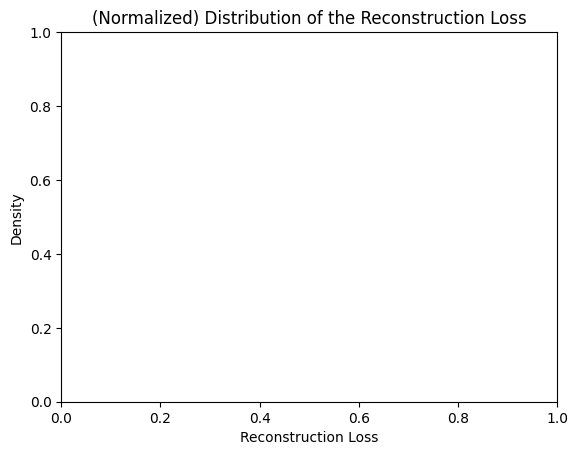

In [443]:
driver_B = mse[y_test==0]
driver_A = mse[y_test==1]

# fig, ax = plt.subplots(figsize=(6,6))

# Plot histograms with transparency and density normalization
ax.hist(driver_B, bins=30, label="driver_B", color="green", alpha=0.5, density=True)
ax.hist(driver_A, bins=30, label="driver_A", color="red", alpha=0.5, density=True)

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.xlabel("Reconstruction Loss")
plt.ylabel("Density")
plt.show()

In [444]:
driver_B

array([0.00172497, 0.00062328, 0.00200687, ..., 0.00792322, 0.00132153,
       0.00981749])

In [445]:
driver_B.shape

(1323,)

In [446]:
driver_A

array([4.23318735e+01, 1.88047928e-02, 1.33665518e-02, 1.32159258e+01,
       1.68518287e+01, 2.76677849e+01, 4.39007113e-02, 3.91299101e+01,
       1.16303642e-02, 5.92409537e+00, 9.56305434e-03, 9.80121274e-03,
       3.82400886e-02, 6.16611618e-02, 1.14425987e-02, 3.23441945e+01,
       7.16405669e+00, 5.47541198e+00, 1.86158658e-03, 7.94106433e-03,
       2.79540474e+01, 5.92421080e-03, 4.40412487e-02, 5.41092878e+00,
       9.34479010e+00, 1.23869461e+01, 2.49564706e-02, 9.48100145e-02,
       6.35918015e+00, 7.59801186e+00, 6.10114110e+00, 1.62214451e+01,
       1.71179072e-02, 1.91270934e-02, 3.10171283e-02, 4.57821484e-03,
       4.64790474e-02, 3.99149043e+01, 1.47583756e+01, 2.67090915e+01,
       1.80302310e+01, 8.90583125e-03, 7.56291184e-03, 4.66659700e+01,
       1.60639606e-02, 2.39596887e+01, 3.53733416e-02, 4.44773228e+01,
       9.99818999e-03, 1.28562270e-02, 1.33389327e-02, 4.51751861e+01,
       5.73950811e+00, 7.63854962e+00, 8.19703449e-03, 9.04578369e-03,
      

In [447]:
driver_A.shape

(400,)

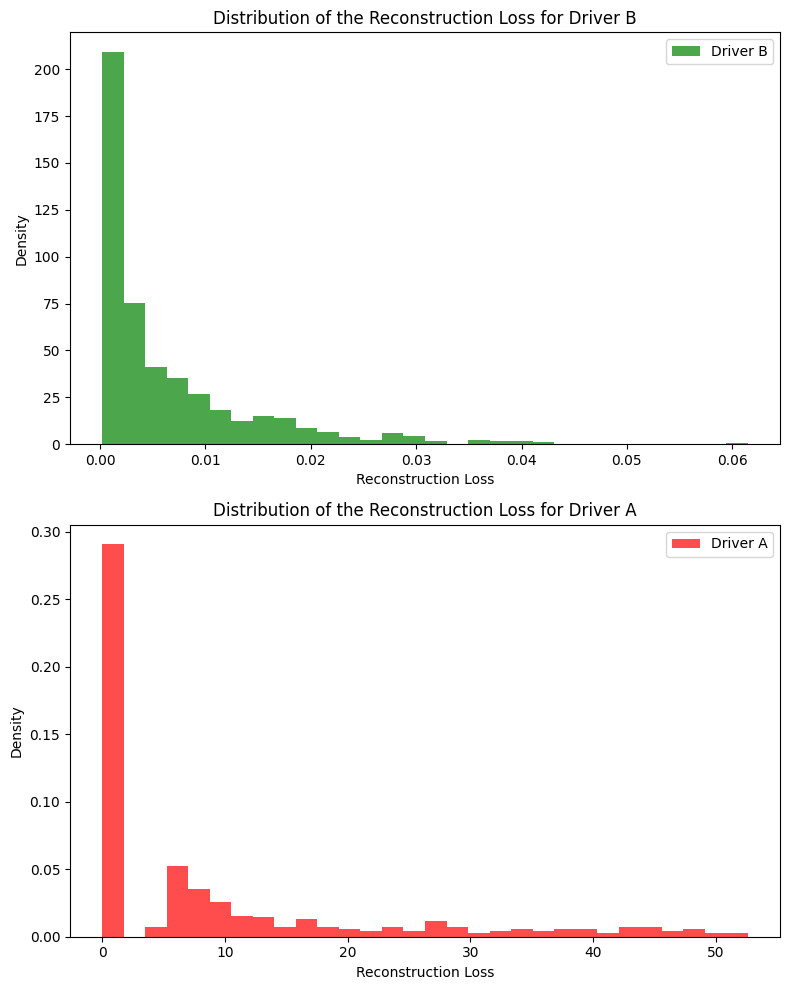

In [448]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot histogram for driver B
ax1.hist(driver_B, bins=30, label="Driver B", color="green", alpha=0.7, density=True)
ax1.set_title("Distribution of the Reconstruction Loss for Driver B")
ax1.set_xlabel("Reconstruction Loss")
ax1.set_ylabel("Density")
ax1.legend()

# Plot histogram for driver A
ax2.hist(driver_A, bins=30, label="Driver A", color="red", alpha=0.7, density=True)
ax2.set_title("Distribution of the Reconstruction Loss for Driver A")
ax2.set_xlabel("Reconstruction Loss")
ax2.set_ylabel("Density")
ax2.legend()

plt.tight_layout()
plt.show()

## Setting a threshold for classification

In [449]:
def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)

    return 0.6745 * ad / mad

In [450]:
THRESHOLD = 1.4
z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

In [451]:
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")


Detected 508 outliers in a total of 1,723 transactions [29.48%].


In [452]:
from sklearn.metrics import (confusion_matrix,
                             precision_recall_curve)

# get (mis)classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp,
 fn, tp) = cm.flatten()

In [453]:
print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of transactions labeled as driver_A that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of driver_A transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=1.4 are as follows:
[[1130  193]
 [  85  315]]

% of transactions labeled as driver_A that were correct (precision): 315/(193+315) = 62.01%
% of driver_A transactions were caught succesfully (recall):    315/(85+315) = 78.75%


## **Test Dataset:**

*   normal driver : 1323 examples
*   anomalous driver : 400 examples

**at THRESHOLD = 1.4**

*   % of transactions labeled as driver_A that were correct(precision): 315/(193+315) = 62.01%

*   % of driver_A transactions were caught succesfully (recall):    315/(85+315) = 78.75%

**at THRESHOLD = 1.6**

*   % of transactions labeled as driver_A that were correct(precision): 315/(193+315) = 65.20%

*   % of driver_A transactions were caught succesfully (recall):    315/(85+315) = 77.75%





